In [ ]:
#Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.layers as L
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
import seaborn as sns

import nltk
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import TweetTokenizer, word_tokenize 
from nltk.corpus import stopwords

import re
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


# Data

In [ ]:
#import data
train=pd.read_csv("drive/MyDrive/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_train.csv",encoding='latin1')
test=pd.read_csv("drive/MyDrive/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_test.csv",encoding='latin1')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [ ]:
train['OriginalTweet']=train['OriginalTweet'].astype(str)
train['Sentiment']=train['Sentiment'].astype(str)
test['OriginalTweet']=test['OriginalTweet'].astype(str)
test['Sentiment']=test['Sentiment'].astype(str)

In [ ]:
#look at NaN
nan = pd.DataFrame(train.isna().sum(), columns = ['NaN_sum'])
num_of_rows=41157
nan['Perc(%)'] = (nan['NaN_sum']/num_of_rows)*100
nan = nan[nan['NaN_sum'] > 0]
nan = nan.sort_values(by = ['NaN_sum'])
nan

,NaN_sum,Perc(%)
Location,8590,20.871298


In [ ]:
#distribution of labels
train.Sentiment.value_counts(normalize= True)

Positive              0.277523
Negative              0.240955
Neutral               0.187404
Extremely Positive    0.160945
Extremely Negative    0.133173
Name: Sentiment, dtype: float64

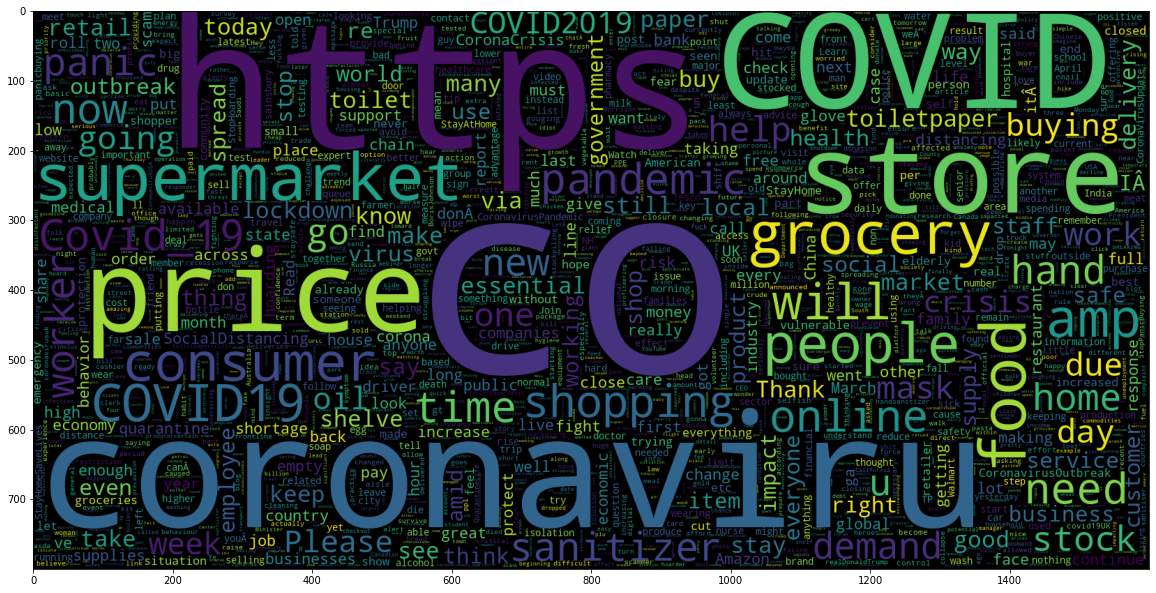

In [ ]:
from wordcloud import WordCloud
text=list(train['OriginalTweet'])
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 35900 , width = 1600 , height = 800,collocations=False).generate(" ".join(text))
plt.imshow(wc)

In [ ]:
#data preprocessing
X = train['OriginalTweet'].copy()
y = train['Sentiment'].copy()


In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
def data_cleaner(tweet):
    # remove html tags
    tweet = re.sub(r'<.*?>',' ', tweet)
    # remove urls
    tweet = re.sub(r'http\S+', ' ', tweet)
    # remove hashtags
    tweet = re.sub(r'#\w+',' ', tweet)
    # remove mentions
    tweet = re.sub(r'@\w+',' ', tweet) 
    # remove digits
    tweet = re.sub(r'\d+',' ', tweet)
    #removing stop words
    tweet = tweet.split()
    stop_words = stopwords.words('english')
    tweet = " ".join([word for word in tweet if not word in stop_words])  
    return tweet

X = X.apply(data_cleaner)
X.head()

0                                                     
1    advice Talk neighbours family exchange phone n...
2    Coronavirus Australia: Woolworths give elderly...
3    My food stock one empty... PLEASE, panic, THER...
4    Me, ready go supermarket outbreak. Not I'm par...
Name: OriginalTweet, dtype: object

In [ ]:
#tokenize
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)

print("Vocabulary size: ",len(tokenizer.word_index)+1)

Vocabulary size:  35900


In [ ]:
#padd text
X = pad_sequences(X, padding='post')

In [ ]:
#feature encoding
encoding = {'Extremely Negative': 0,
            'Negative': 1,
            'Neutral': 2,
            'Positive':3,
            'Extremely Positive': 4
           }

y.replace(encoding, inplace=True)

**bold text**# Models

In [ ]:
tf.keras.backend.clear_session()

# hyper parameters
EPOCHS = 5
BATCH_SIZE = 32
embedding_dim = 16
units = 256

model = tf.keras.Sequential([
    L.Embedding(len(tokenizer.word_index)+1, embedding_dim, input_length=X.shape[1]),
    L.Conv1D(filters = 8, kernel_size = 4,data_format='channels_first'),
    L.Dropout(0.4),
    L.Conv1D(filters = 8, kernel_size = 4,data_format='channels_first'),
    L.Dropout(0.4),
    L.Conv1D(filters = 8, kernel_size = 4,data_format='channels_first'),
    L.Dropout(0.4),
    L.Flatten(),
    L.Dense(64, activation="relu"),
    L.Dropout(0.4),
    L.Dense(5)
])

model.compile(loss=SparseCategoricalCrossentropy(from_logits=True),optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 54, 16)            574400    
_________________________________________________________________
conv1d (Conv1D)              (None, 8, 13)             1736      
_________________________________________________________________
dropout (Dropout)            (None, 8, 13)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 8, 10)             264       
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 10)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 8, 7)              264       
_________________________________________________________________
dropout_2 (Dropout)          (None, 8, 7)              0

In [ ]:
model.fit(X, y, epochs=EPOCHS, validation_split=0.1, batch_size=BATCH_SIZE)

Epoch 1/5
1158/1158 [==============================] - 15s 7ms/step - loss: 1.5014 - accuracy: 0.3137 - val_loss: 0.9633 - val_accuracy: 0.6215
Epoch 2/5
1158/1158 [==============================] - 8s 7ms/step - loss: 0.8908 - accuracy: 0.6496 - val_loss: 0.7853 - val_accuracy: 0.7024
Epoch 3/5
1158/1158 [==============================] - 7s 6ms/step - loss: 0.6357 - accuracy: 0.7631 - val_loss: 0.7639 - val_accuracy: 0.7111
Epoch 4/5
1158/1158 [==============================] - 7s 6ms/step - loss: 0.5186 - accuracy: 0.8165 - val_loss: 0.8349 - val_accuracy: 0.7133
Epoch 5/5
1158/1158 [==============================] - 7s 6ms/step - loss: 0.4382 - accuracy: 0.8495 - val_loss: 0.8661 - val_accuracy: 0.7106


# Evaluation

In [ ]:
X_test = test['OriginalTweet'].copy()
y_test = test['Sentiment'].copy()
X_test = X_test.apply(data_cleaner)
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, padding='post',maxlen=54)
y_test.replace(encoding, inplace=True)

In [ ]:
print(X.shape)
print(X_test.shape)

(41157, 54)
(3798, 54)


In [ ]:
prediction = model.predict_classes(X_test)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning:

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).



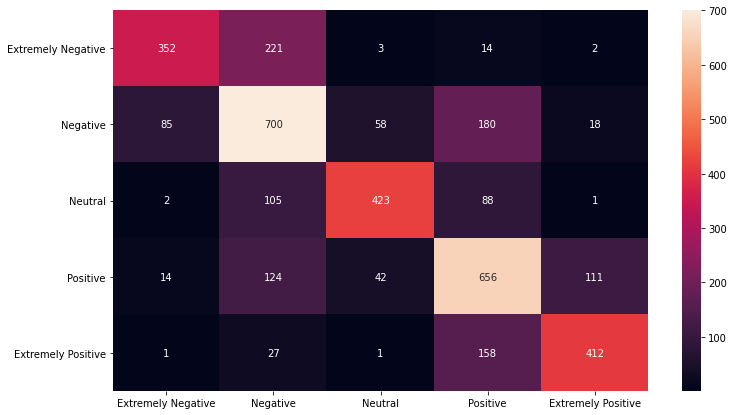

In [ ]:
conf = confusion_matrix(y_test, prediction)
labels = ['Extremely Negative','Negative', 'Neutral', 'Positive','Extremely Positive']
conf = pd.DataFrame( conf, index = [i for i in labels],columns = [i for i in labels])
plt.figure(figsize = (12,7))
sns.heatmap(conf, annot=True, fmt="d")
plt.show()

In [ ]:
print(classification_report(y_test, prediction, target_names=labels))

                    precision    recall  f1-score   support

Extremely Negative       0.78      0.59      0.67       592
          Negative       0.59      0.67      0.63      1041
           Neutral       0.80      0.68      0.74       619
          Positive       0.60      0.69      0.64       947
Extremely Positive       0.76      0.69      0.72       599

          accuracy                           0.67      3798
         macro avg       0.71      0.67      0.68      3798
      weighted avg       0.68      0.67      0.67      3798

